

### LifeLong Machine Learning
### TA's Slide
[Slide](https://docs.google.com/presentation/d/1SMJLWPTPCIrZdNdAjrS4zQZx1kfB73jCFSb7JRX90gQ/edit?usp=sharing)

### Definition
The detailed explanations and definitions of LifeLong Learning please refer to [LifeLong learning](https://youtu.be/7qT5P9KJnWo) 


### Methods
Someone proposed a survey paper for LifeLong Learning at the end of 2019 to distinguish 2016-2019 LigeLong Learning methods into three families.

We can distinguish LifeLong Learning methods into three families, based on how task
specific information is stored and used throughout the sequential learning process:
* Replay-based methods
* Regularization-based methods
* Parameter isolation methods

<img src="https://i.ibb.co/VDFJkWG/2019-12-29-17-25.png" width="100%">

In this assignment, we have to go through EWC, MAS, SI, Remanian Walk, SCP Methods in the prior-focused methods of the regularization-based methods. 

Source: [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

Please feel free to mail us if you have any questions.

ntu-ml-2022spring-ta@googlegroups.com


# Utilities

### Import Libraries

In [ ]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import tqdm
from tqdm import trange

### Check devices

In [ ]:
!nvidia-smi

Tue May 24 04:16:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Fix Random Seeds

In [ ]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

# Prepare Data
We utilize rotated MNIST as our training dataset.

So, first, we utilize 5 different rotations to generate 10 different rotated MNISTs as different tasks.

### Rotation and Transformation

In [ ]:
# Rotate MNIST to generate 10 tasks

def _rotate_image(image, angle):
  if angle is None:
    return image

  image = transforms.functional.rotate(image, angle=angle)
  return image

def get_transform(angle=None):
  transform = transforms.Compose([transforms.ToTensor(),
                   transforms.Lambda(lambda x: _rotate_image(x, angle)),
                   Pad(28)
                   ])
  return transform

class Pad(object):
  def __init__(self, size, fill=0, padding_mode='constant'):
    self.size = size
    self.fill = fill
    self.padding_mode = padding_mode
    
  def __call__(self, img):
    # If the H and W of img is not equal to desired size,
    # then pad the channel of img to desired size.
    img_size = img.size()[1]
    assert ((self.size - img_size) % 2 == 0)
    padding = (self.size - img_size) // 2
    padding = (padding, padding, padding, padding)
    return F.pad(img, padding, self.padding_mode, self.fill)

class Data():
  def __init__(self, path, train=True, angle=None):
    transform = get_transform(angle)
    self.dataset = datasets.MNIST(root=os.path.join(path, "MNIST"), transform=transform, train=train, download=True)

### Dataloaders and Arguments
- Training Arguments
- Setup 5 different Rotations
- 5 Train DataLoader
- 5 Test DataLoader 

In [ ]:
class Args:
  task_number = 5
  epochs_per_task = 10
  lr = 1.0e-4
  batch_size = 128
  test_size=8192

args=Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# generate rotations for the tasks.

# generate rotated MNIST data from 10 different rotations.

angle_list = [20 * x for x in range(args.task_number)]

# prepare rotated MNIST datasets.

train_datasets = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]
train_dataloaders = [DataLoader(data.dataset, batch_size=args.batch_size, shuffle=True) for data in train_datasets]

test_datasets = [Data('data', train=False, angle=angle_list[index]) for index in range(args.task_number)]
test_dataloaders = [DataLoader(data.dataset, batch_size=args.test_size, shuffle=True) for data in test_datasets]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



### Visualization

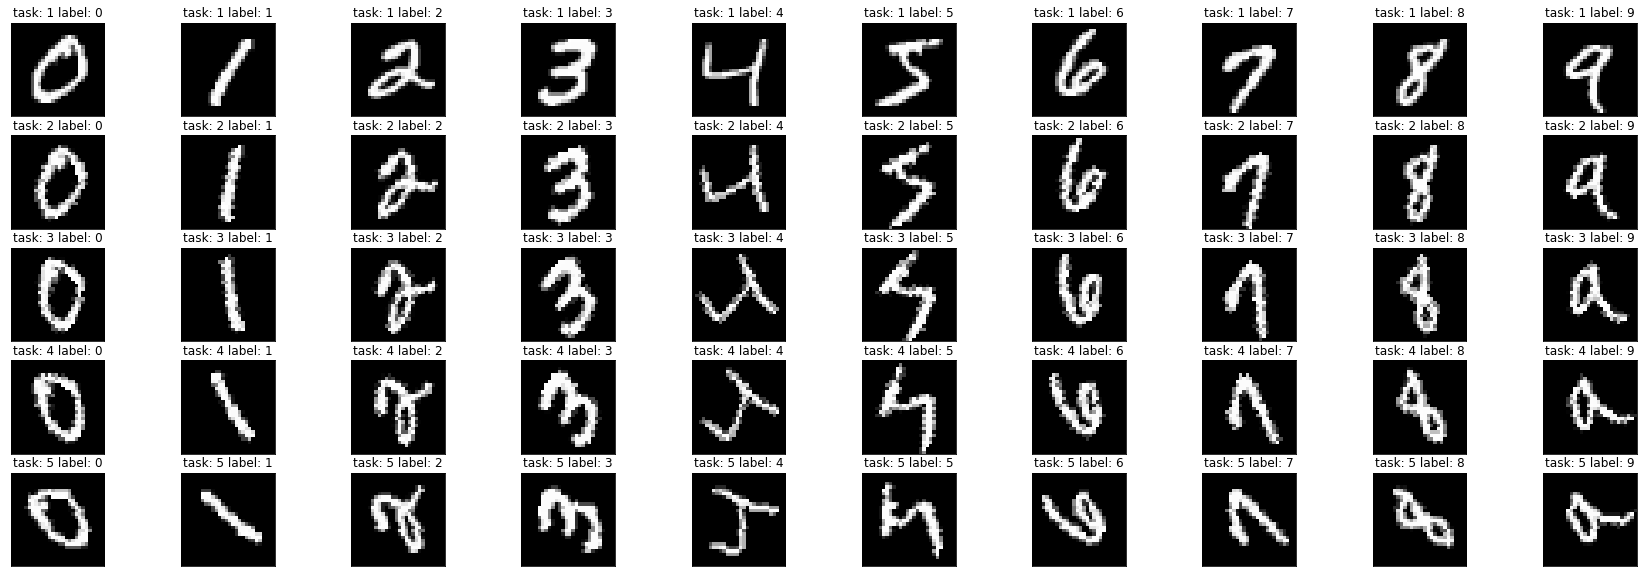

In [ ]:
# Visualize label 0-9 1 sample MNIST picture in 5 tasks.
sample = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]

plt.figure(figsize=(30, 10))
for task in range(5):
  target_list = []
  cnt = 0
  while (len(target_list) < 10):
    img, target = sample[task].dataset[cnt]
    cnt += 1
    if target in target_list:
      continue
    else:
      target_list.append(target)
    plt.subplot(5, 10, (task)*10 + target + 1)
    curr_img = np.reshape(img, (28, 28))
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'), fignum=False)
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.title("task: " + str(task+1) + " " + "label: " + str(target), y=1)

# Prepare Model

### Model Architecture
To fair comparison, 

We fix our model architecture to do this homework. 

The model architecture consists of 4 layers fully-connected network.

In [ ]:
class Model(nn.Module):
  """
  Model architecture 
  1*28*28 (input) → 1024 → 512 → 256 → 10
  """
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(1*28*28, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 1*28*28)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    return x

example = Model()
print(example)

Model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


# Train and Evaluate

### Train
This is our function of training.

It can generally be applied in different regularization-based lifelong learning algorithms in this homework.

In [ ]:
def train(model, optimizer, dataloader, epochs_per_task, lll_object, lll_lambda, test_dataloaders, evaluate, device, log_step=1):
  model.train()
  model.zero_grad()
  objective = nn.CrossEntropyLoss()
  acc_per_epoch = []
  loss = 1.0
  bar = tqdm.auto.trange(epochs_per_task, leave=False, desc=f"Epoch 1, Loss: {loss:.7f}")
  for epoch in bar:
    for imgs, labels in tqdm.auto.tqdm(dataloader, leave=False):            
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      loss = objective(outputs, labels)
      total_loss = loss
      lll_loss = lll_object.penalty(model)
      total_loss += lll_lambda * lll_loss 
      lll_object.update(model)
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      loss = total_loss.item()
      bar.set_description_str(desc=f"Epoch {epoch+1:2}, Loss: {loss:.7f}", refresh=True)
    acc_average  = []
    for test_dataloader in test_dataloaders: 
      acc_test = evaluate(model, test_dataloader, device)
      acc_average.append(acc_test)
    average=np.mean(np.array(acc_average))
    acc_per_epoch.append(average*100.0)
    bar.set_description_str(desc=f"Epoch {epoch+2:2}, Loss: {loss:.7f}", refresh=True)
                
  return model, optimizer, acc_per_epoch

### Evaluate
This is our function of evaluation.

It can generally be applied in different regularization-based lifelong learning algorithms in this homework.


In [ ]:
def evaluate(model, test_dataloader, device):
    model.eval()
    correct_cnt = 0
    total = 0
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred_label = torch.max(outputs.data, 1)

        correct_cnt += (pred_label == labels.data).sum().item()
        total += torch.ones_like(labels.data).sum().item()
    return correct_cnt / total

# Methods
- Baseline
- EWC
- SI
- MAS
- RWalk
- SCP

### Baseline
The baseline class will do nothing in the regularization term.

In [ ]:
# Baseline
class baseline(object):
  """
  baseline technique: do nothing in regularization term [initialize and all weight is zero]
  """
  def __init__(self, model, dataloader, device):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
    
    # store current parameters
    self.p_old = {} 

    # generate weight matrix
    self._precision_matrices = self._calculate_importance()  

    for n, p in self.params.items():
      # keep the old parameter in self.p_old
      self.p_old[n] = p.clone().detach() 

  def _calculate_importance(self):
    precision_matrices = {} 
    # initialize weight matrix（fill zero）
    for n, p in self.params.items(): 
      precision_matrices[n] = p.clone().detach().fill_(0)

    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
      loss += _loss.sum()
    return loss
  
  def update(self, model):
    # do nothing
    return

In [ ]:
# Baseline
print("RUN BASELINE")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object (baseline class) without adding any regularization term.
lll_object=baseline(model=model, dataloader=None, device=device)
lll_lambda=0.0
baseline_acc=[]
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")

# iterate training on each task continually.
for train_indexes in task_bar:
  # Train each task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, 
                  lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight to baseline class and do nothing!
  lll_object=baseline(model=model, dataloader=train_dataloaders[train_indexes],device=device)
  
  # new a optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  
  # Collect average accuracy in each epoch
  baseline_acc.extend(acc_list)
  
  # display the information of the next task.
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch! 
print(baseline_acc)
print("==================================================================================================")

### EWC

Elastic Weight Consolidation

The ewc class applied EWC algorithm to calculate the regularization term. The central concept is included in Prof.Hung-yi's lectures. Here we will focus on the algorithm of EWC.

In this assignment, we want to let our model learn 10 tasks successively. Here we show a simple example that lets the model learn 2 tasks(task A and task B) successively.

In the EWC algorithm, the definition of the loss function is shown below:
 $$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2  $$
  
Assume we have a neural network with more than two parameters.

$F_i$ corresponds to the $i^{th}$ guard in Prof. Hung-yi's lecture. Please do not modify this parameter, because it's important to task A.

The definition of $F$ is shown below.
$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*})) \nabla \log(p(y_n | x_n, \theta_{A}^{*}))^T ] $$ 

We only take the diagonal value of the matrix to approximate each parameter's $F_i$.

The detail information and derivation are shown in 2.4.1 and 2.4 of [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

For You Information: [Elastic Weight Consolidation](https://arxiv.org/pdf/1612.00796.pdf)

In [ ]:
# EWC
class ewc(object):
  """
  @article{kirkpatrick2017overcoming,
      title={Overcoming catastrophic forgetting in neural networks},
      author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
      journal={Proceedings of the national academy of sciences},
      year={2017},
      url={https://arxiv.org/abs/1612.00796}
  }
  """
  def __init__(self, model, dataloader, device, prev_guards=[None]):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
    
    # initialize parameters
    self.p_old = {}
    # save previous guards
    self.previous_guards_list = prev_guards

    # generate Fisher (F) matrix for EWC
    self._precision_matrices = self._calculate_importance()                   

    # keep the old parameter in self.p_old
    for n, p in self.params.items():
      self.p_old[n] = p.clone().detach()       

  def _calculate_importance(self):
    precision_matrices = {}
    # initialize Fisher (F) matrix（all fill zero）and add previous guards
    for n, p in self.params.items(): 
      precision_matrices[n] = p.clone().detach().fill_(0)                 
      for i in range(len(self.previous_guards_list)):
        if self.previous_guards_list[i]:
          precision_matrices[n] += self.previous_guards_list[i][n]

    self.model.eval()
    if self.dataloader is not None:
      number_data = len(self.dataloader)
      for data in self.dataloader:
        self.model.zero_grad()
        # get image data
        input = data[0].to(self.device)
          
        # image data forward model
        output = self.model(input)
          
        # Simply use groud truth label of dataset.  
        label = data[1].to(self.device)
          
        # generate Fisher(F) matrix for EWC     
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()   

        for n, p in self.model.named_parameters():
          # get the gradient of each parameter and square it, then average it in all validation set.                          
          precision_matrices[n].data += p.grad.data ** 2 / number_data   
                                                                
      precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      # generate the final regularization term by the ewc weight (self._precision_matrices[n]) and the square of weight difference ((p - self.p_old[n]) ** 2).  
      _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
      loss += _loss.sum()
    return loss
  
  def update(self, model):
    # do nothing
    return 

In [ ]:
# EWC
print("RUN EWC")
model = Model()
model = model.to(device)
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object for EWC
lll_object=ewc(model=model, dataloader=None, device=device)

# setup the coefficient value of regularization term.
lll_lambda=100
ewc_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
prev_guards = []

# iterate training on each task continually.
for train_indexes in task_bar:
  # Train Each Task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight and calculate guidance for each weight
  prev_guards.append(lll_object._precision_matrices)
  lll_object=ewc(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

  # new a Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

  # collect average accuracy in each epoch
  ewc_acc.extend(acc_list)

  # Update tqdm displayer
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(ewc_acc)
print("==================================================================================================")

### MAS
Memory Aware Synapses

The mas class applied MAS algorithm to calculate the regularization term.

The concept of MAS is similar to EWC, the only difference is the calculation of the important weight. 
The details are mentioned in the following blocks.

MAS:

In MAS, the Loss function is shown below, the model learns task A before it learned task B.

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

Compare with EWC, the $F_i$ in the loss function is replaced with $\Omega_i$ in the following function.

$$\Omega_i = || \frac{\partial \ell_2^2(M(x_k; \theta))}{\partial \theta_i} || $$ 

$x_k$ is the sample data of the previous task. So the $\Omega$ is obtained gradients of the squared L2-norm of the learned network output.

The method proposed in the paper is the local version by taking squared L2-norm outputs from each layer of the model.

Here we only want you to implement the global version by taking outputs from the last layer of the model.

For Your Information: 
[Memory Aware Synapses](https://arxiv.org/pdf/1711.09601.pdf)

In [ ]:
class mas(object):
  """
  @article{aljundi2017memory,
      title={Memory Aware Synapses: Learning what (not) to forget},
      author={Aljundi, Rahaf and Babiloni, Francesca and Elhoseiny, Mohamed and Rohrbach, Marcus and Tuytelaars, Tinne},
      booktitle={ECCV},
      year={2018},
      url={https://eccv2018.org/openaccess/content_ECCV_2018/papers/Rahaf_Aljundi_Memory_Aware_Synapses_ECCV_2018_paper.pdf}
  }
  """
  def __init__(self, model: nn.Module, dataloader, device, prev_guards=[None]):
    self.model = model 
    self.dataloader = dataloader
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
    
    # initialize parameters
    self.p_old = {} 
    
    self.device = device

    # save previous guards
    self.previous_guards_list = prev_guards
    
    # generate Omega(Ω) matrix for MAS
    self._precision_matrices = self.calculate_importance() 

    # keep the old parameter in self.p_old
    for n, p in self.params.items():
      self.p_old[n] = p.clone().detach() 
  
  def calculate_importance(self):
    precision_matrices = {}
    # initialize Omega(Ω) matrix（all filled zero）
    for n, p in self.params.items():
      precision_matrices[n] = p.clone().detach().fill_(0) 
      for i in range(len(self.previous_guards_list)):
        if self.previous_guards_list[i]:
          precision_matrices[n] += self.previous_guards_list[i][n]

    self.model.eval()
    if self.dataloader is not None:
      num_data = len(self.dataloader)
      for data in self.dataloader:
        self.model.zero_grad()
        output = self.model(data[0].to(self.device))
        ################################################################
        #####  TODO: generate Omega(Ω) matrix for MAS.  #####   
        ################################################################
        pass   
        ################################################################                  
    
      precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
      loss += _loss.sum()
    return loss

  def update(self, model):
    # do nothing
    return 

In [ ]:
# MAS
print("RUN MAS")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=mas(model=model, dataloader=None, device=device)
lll_lambda=0.1
mas_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
prev_guards = []

for train_indexes in task_bar:
  # Train Each Task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight and calculate guidance for each weight
  prev_guards.append(lll_object._precision_matrices)
  lll_object=mas(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

  # New a Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

  # Collect average accuracy in each epoch
  mas_acc.extend(acc_list)
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(mas_acc)
print("==================================================================================================")

### SI
The si class applied SI (Synaptic Intelligence) algorithm to calculate the regularization term.

In [ ]:
# SI
class si(object):
  """
  @article{kirkpatrick2017overcoming,
      title={Overcoming catastrophic forgetting in neural networks},
      author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
      journal={Proceedings of the national academy of sciences},
      year={2017},
      url={https://arxiv.org/abs/1612.00796}
  }
  """
  def __init__(self, model, dataloader, epsilon, device):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    self.epsilon = epsilon
    # extract all parameters in models
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
    
    self._n_p_prev, self._n_omega = self._calculate_importance() 
    self.W, self.p_old = self._init_()
    

  def _init_(self):
    W = {}
    p_old = {}
    for n, p in self.model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        W[n] = p.data.clone().zero_()
        p_old[n] = p.data.clone()
    return W, p_old

  def _calculate_importance(self):
    n_p_prev = {}
    n_omega = {}

    if self.dataloader != None:
      for n, p in self.model.named_parameters():
        n = n.replace('.', '__')
        if p.requires_grad:
          # Find/calculate new values for quadratic penalty on parameters
          p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
          W = getattr(self.model, '{}_W'.format(n))
          p_current = p.detach().clone()
          p_change = p_current - p_prev
          omega_add = W/(p_change**2 + self.epsilon)
          try:
            omega = getattr(self.model, '{}_SI_omega'.format(n))
          except AttributeError:
            omega = p.detach().clone().zero_()
          omega_new = omega + omega_add
          n_omega[n] = omega_new
          n_p_prev[n] = p_current

          # Store these new values in the model
          self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
          self.model.register_buffer('{}_SI_omega'.format(n), omega_new)

    else:
      for n, p in self.model.named_parameters():
        n = n.replace('.', '__')
        if p.requires_grad:
          n_p_prev[n] = p.detach().clone()
          n_omega[n] = p.detach().clone().zero_()
          self.model.register_buffer('{}_SI_prev_task'.format(n), p.detach().clone())
    return n_p_prev, n_omega

  def penalty(self, model: nn.Module):
    loss = 0.0
    for n, p in model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        prev_values = self._n_p_prev[n]
        omega = self._n_omega[n]
        _loss = omega * (p - prev_values) ** 2
        loss += _loss.sum()
    return loss
  
  def update(self, model):
    for n, p in model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        if p.grad is not None:
          self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
          self.model.register_buffer('{}_W'.format(n), self.W[n])
        self.p_old[n] = p.detach().clone()
    return 

In [ ]:
# SI
print("RUN SI")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=si(model=model, dataloader=None, epsilon=0.1, device=device)
lll_lambda=1
si_acc = []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")

for train_indexes in task_bar:
  # Train Each Task
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  
  # get model weight and calculate guidance for each weight
  lll_object=si(model=model, dataloader=train_dataloaders[train_indexes], epsilon=0.1, device=device)

  # New a Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

  # Collect average accuracy in each epoch
  si_acc.extend(acc_list)
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(si_acc)
print("==================================================================================================")

### RWalk

#### Remanian Walk for Incremental Learning

The rwalk class applied Remanian Walk algorithm to calculate the regularization term.

The details are mentioned in the following blocks.

In [ ]:
class rwalk(object):
  def __init__(self, model, dataloader, epsilon, device, prev_guards=[None]):
    self.model = model
    self.dataloader = dataloader
    self.device = device
    self.epsilon = epsilon
    self.update_ewc_parameter = 0.4
    # extract model parameters and store in dictionary
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
    
    # initialize the guidance matrix
    self._means = {} 

    self.previous_guards_list = prev_guards
    
    # Generate Fisher (F) Information Matrix
    self._precision_matrices = self._calculate_importance_ewc()
      
    self._n_p_prev, self._n_omega = self._calculate_importance() 
    self.W, self.p_old = self._init_()

  def _init_(self):
    W = {}
    p_old = {}
    for n, p in self.model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        W[n] = p.data.clone().zero_()
        p_old[n] = p.data.clone()
    return W, p_old

  def _calculate_importance(self):
    n_p_prev = {}
    n_omega = {}

    if self.dataloader is not None:
      for n, p in self.model.named_parameters():
        n = n.replace('.', '__')
        if p.requires_grad:
          # Find/calculate new values for quadratic penalty on parameters
          p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
          W = getattr(self.model, '{}_W'.format(n))
          p_current = p.detach().clone()
          p_change = p_current - p_prev
          omega_add = W / (1.0 / 2.0*self._precision_matrices[n] *p_change**2 + self.epsilon)
          try:
              omega = getattr(self.model, '{}_SI_omega'.format(n))
          except AttributeError:
              omega = p.detach().clone().zero_()
          omega_new = 0.5 * omega + 0.5 *omega_add
          n_omega[n] = omega_new
          n_p_prev[n] = p_current

          # Store these new values in the model
          self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
          self.model.register_buffer('{}_SI_omega'.format(n), omega_new)

    else:
      for n, p in self.model.named_parameters():
        n = n.replace('.', '__')
        if p.requires_grad:
          n_p_prev[n] = p.detach().clone()
          n_omega[n] = p.detach().clone().zero_()
          self.model.register_buffer('{}_SI_prev_task'.format(n), p.detach().clone())
    return n_p_prev, n_omega
  
  def _calculate_importance_ewc(self):
    precision_matrices = {}
    for n, p in self.params.items():
      # initialize Fisher (F) matrix（all fill zero） 
      n = n.replace('.', '__') 
      precision_matrices[n] = p.clone().detach().fill_(0)
      for i in range(len(self.previous_guards_list)):
        if self.previous_guards_list[i]:
          precision_matrices[n] += self.previous_guards_list[i][n]
           

    self.model.eval()
    if self.dataloader is not None:
      number_data = len(self.dataloader)
      for n, p in self.model.named_parameters():                         
        n = n.replace('.', '__')
        precision_matrices[n].data *= (1 - self.update_ewc_parameter)
      for data in self.dataloader:
        self.model.zero_grad()
        input = data[0].to(self.device)
        output = self.model(input)
        label = data[1].to(self.device)

        # generate Fisher(F) matrix for RWALK    
        loss = F.nll_loss(F.log_softmax(output, dim=1), label) 
        loss.backward()                                                    
                                                                          
        for n, p in self.model.named_parameters():                         
          n = n.replace('.', '__')
          precision_matrices[n].data += self.update_ewc_parameter*p.grad.data ** 2 / number_data  
                                                                  
      precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0.0
    for n, p in model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        prev_values = self._n_p_prev[n]
        omega = self._n_omega[n]
        # Generate regularization term  _loss by omega and Fisher Matrix
        _loss = (omega + self._precision_matrices[n]) * (p - prev_values) ** 2
        loss += _loss.sum()

    return loss
  
  def update(self, model):
    for n, p in model.named_parameters():
      n = n.replace('.', '__')
      if p.requires_grad:
        if p.grad is not None:
          self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
          self.model.register_buffer('{}_W'.format(n), self.W[n])
        self.p_old[n] = p.detach().clone()
    return 

In [ ]:
# RWalk
print("RUN Rwalk")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=rwalk(model=model, dataloader=None, epsilon=0.1, device=device)
lll_lambda=100
rwalk_acc = []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
prev_guards = []

for train_indexes in task_bar:
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  prev_guards.append(lll_object._precision_matrices)
  lll_object=rwalk(model=model, dataloader=train_dataloaders[train_indexes], epsilon=0.1, device=device, prev_guards=prev_guards)
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  rwalk_acc.extend(acc_list)
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(rwalk_acc)
print("==================================================================================================")

### SCP
Sliced Cramer Preservation

Pseudo Code:
<img src="https://i.ibb.co/QJycmNZ/2021-02-18-21-07.png" width="100%">

In [ ]:
def sample_spherical(npoints, ndim=3):
  vec = np.random.randn(ndim, npoints)
  vec /= np.linalg.norm(vec, axis=0)
  return torch.from_numpy(vec)

class scp(object):
  """
  OPEN REVIEW VERSION:
  https://openreview.net/forum?id=BJge3TNKwH
  """
  def __init__(self, model: nn.Module, dataloader, L: int, device, prev_guards=[None]):
    self.model = model 
    self.dataloader = dataloader
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
    self._state_parameters = {}
    self.L= L
    self.device = device
    self.previous_guards_list = prev_guards
    self._precision_matrices = self.calculate_importance()
    for n, p in self.params.items():
      self._state_parameters[n] = p.clone().detach()
  
  def calculate_importance(self):
    precision_matrices = {}
    for n, p in self.params.items():
      precision_matrices[n] = p.clone().detach().fill_(0)
      for i in range(len(self.previous_guards_list)):
        if self.previous_guards_list[i]:
          precision_matrices[n] += self.previous_guards_list[i][n]

    self.model.eval()
    if self.dataloader is not None:
      num_data = len(self.dataloader)
      for data in self.dataloader:
        self.model.zero_grad()
        output = self.model(data[0].to(self.device))
          
        mean_vec = output.mean(dim=0)

        L_vectors = sample_spherical(self.L, output.shape[-1])
        L_vectors = L_vectors.transpose(1,0).to(self.device).float()
                    
        total_scalar = 0
        for vec in L_vectors:
          scalar=torch.matmul(vec, mean_vec)
          total_scalar += scalar
        total_scalar /= L_vectors.shape[0] 
        total_scalar.backward()     

        for n, p in self.model.named_parameters():                      
          precision_matrices[n].data += p.grad**2 / num_data      
              
    precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self._state_parameters[n]) ** 2
      loss += _loss.sum()
    return loss
  
  def update(self, model):
    # do nothing
    return 

In [ ]:
# SCP
print("RUN SLICE CRAMER PRESERVATION")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=scp(model=model, dataloader=None, L=100, device=device)
lll_lambda=100
scp_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
prev_guards = []

for train_indexes in task_bar:
  model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
  prev_guards.append(lll_object._precision_matrices)
  lll_object=scp(model=model, dataloader=train_dataloaders[train_indexes], L=100, device=device, prev_guards=prev_guards)
  optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
  scp_acc.extend(acc_list)
  task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(scp_acc)
print("==================================================================================================")

# Plot function

In [ ]:
import matplotlib.pyplot as plt
def draw_acc(acc_list, label_list):
  for acc, label in zip(acc_list, label_list):
    plt.plot(acc, marker='o', lineStyle='--', linewidth=2, markersize=4, label=label)
    plt.legend()
  plt.savefig('acc_summary.png')
  plt.show() 

acc_list = [baseline_acc, ewc_acc, mas_acc, si_acc, rwalk_acc, scp_acc]
label_list = ['baseline', 'EWC', 'MAS', 'SI', 'RWALK', 'SCP']
draw_acc(acc_list, label_list)